# Business Understanding
## Problem Statement

We were given a churn prediction problem. The goal is to predict whether a customer is about to leave (to churn) our bank.
This is a binary classification problem, where the target variable is the 'Exited' column, based on the other columns in the dataset.

## Business Objectives

This is a very important problem for the bank, as it is much more expensive to acquire new customers than to retain existing ones, therefore making it crucial to accurately predict which costumers are leaving, so that the bank can take action to retain them.

![churn.png](images/churn.png)

# Data Understanding and Preparation

The dataset contains 10,000 records and 13 columns (features). The features are as follows:

- **RowNumber**: The row number
- **CustomerId**: The customer ID
- **Surname**: The customer's surname
- **CreditScore**: The customer's credit score
- **Geography**: The customer's country (Spain / France / Germany)
- **Gender**: The customer's gender (Male / Female)
- **Age**: The customer's age
- **Tenure**: The number of years the customer has been with the bank
- **Balance**: The customer's account balance
- **NumOfProducts**: The number of bank products the customer uses
- **HasCrCard**: Whether the customer has a credit card (1 = Yes, 0 = No)
- **IsActiveMember**: Whether the customer is an active member (1 = Yes, 0 = No)
- **EstimatedSalary**: The customer's estimated salary
- **Exited**: Whether the customer has churned (1 = Yes, 0 = No)

First, we will load the data and perform some basic data exploration to understand the data better.

We start by mapping the categorical variables to numerical values, so that we can use them in our models, and dropping the columns that are not relevant for the prediction.


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Read data from csv fil
df = pd.read_csv('../Churn_Modelling.csv')

# Drop irrelevant columns
df = df.drop(columns = ['RowNumber', 'CustomerId', 'Surname'])

# Encode categorical columns
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df_encoded = pd.get_dummies(df, columns = ['Geography'], drop_first = True)
df = df_encoded


numeric_columns = df.select_dtypes(include='number').columns

# Check for negative values
negative_values = (df[numeric_columns] < 0).sum()
if negative_values.sum() == 0:
    print('No negative values')

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print('No missing values')

# Check for invalid age values
invalid_age_values = (df['Age'] < 18) | (df['Age'] > 100)
if invalid_age_values.sum() == 0:
    print('No invalid age values')

# Check for balance between churned and retained customers
# churned when column exited is 1
churned = df['Exited'].sum()
retained = df.shape[0] - churned
print(f'ratio churned/retained: {churned}/{retained}')

min_unique_values = 8
relevant_columns = [col for col in df.columns if (df[col].nunique() >= min_unique_values) or (col == 'Exited')]
relevant_columns_df = df[relevant_columns]

#sns.pairplot(relevant_columns_df, hue='Exited')

No negative values
No missing values
No invalid age values
ratio churned/retained: 2037/7963


## Data Exploration Conclusion
The dataset is also imbalanced, with 79.63% of the customers not churning (Exited = 0) and 20.37% of the customers churning (Exited = 1).

From the pairplots, we can see the model is clean and there are no missing values.


# Data Modeling and Evaluation Metrics

We will start by splitting the data into training and testing sets, and then we will train several models and evaluate their performance using the following metrics:

- **Accuracy**: The proportion of correctly classified instances.
- **Precision**: The proportion of true positive instances among the instances classified as positive.
- **Recall**: The proportion of true positive instances that were correctly classified.
- **F1 Score**: The harmonic mean of precision and recall.

We will train the following models:

- Support Vector Machine
- K-Nearest Neighbors
- Neural Network
- Decision Tree


In [10]:
def plot_results(results):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=results, x='Metric', y='Score', hue='Classifier', palette='viridis')
    plt.title('Comparison of Classification Algorithms')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.legend(title='Classifier')
    plt.show()


def evaluate_classifier(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

def cross_evaluate_classifier(classifier, X_train, y_train, cv):
    accuracy = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='precision').mean()
    recall = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='f1').mean()
    return accuracy, precision, recall, f1

def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [11]:
# Define 'X' (features) and 'y' (target variable)
X = df.drop(columns=['Exited'])
y = df['Exited']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Initialize classifiers
decision_tree_classifier = DecisionTreeClassifier()
k_neighbors_classifier = KNeighborsClassifier()
svm_classifier = SVC(probability=True)
neural_network_classifier = MLPClassifier(max_iter=2000, early_stopping=True)

classifiers = {
    "Decision Tree": decision_tree_classifier,
    "K-Nearest Neighbors": k_neighbors_classifier,
    "Support Vector Machine": svm_classifier,
    "Neural Network": neural_network_classifier
}


In [12]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

                        Accuracy  Precision    Recall  F1-Score
Decision Tree           0.784625   0.475498  0.513982  0.494483
K-Nearest Neighbors     0.822625   0.620137  0.355836  0.451891
Support Vector Machine  0.854875   0.813087  0.382584  0.519864
Neural Network          0.851375   0.749659  0.397214  0.541377


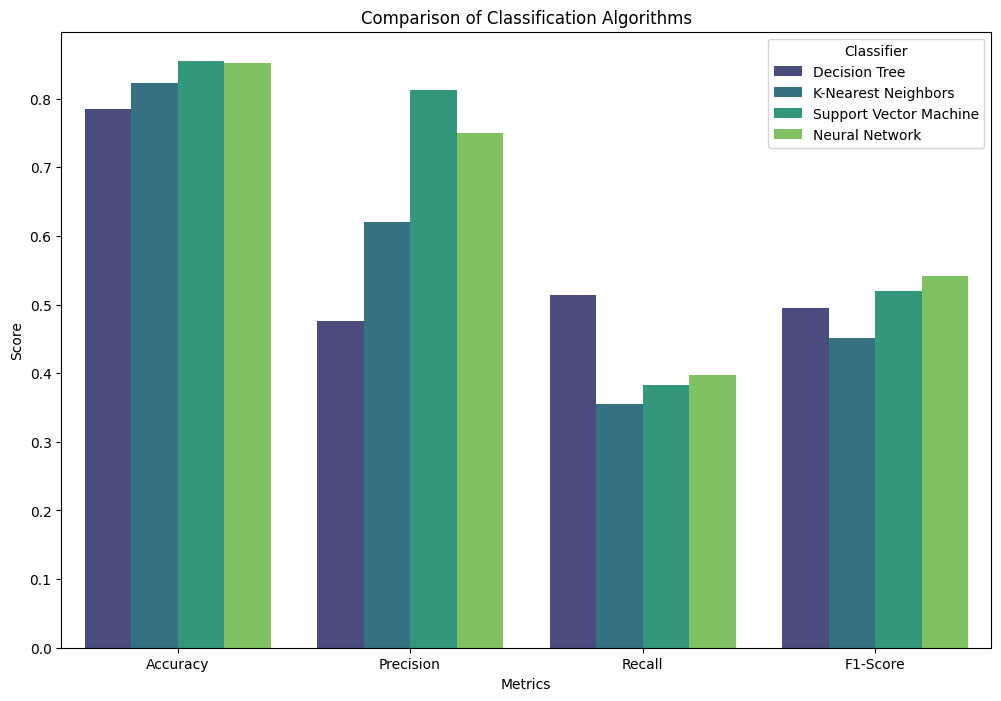

In [13]:

# Evaluate each classifier using cross-validation
results = {}
for name, clf in classifiers.items():
    accuracy, precision, recall, f1 = cross_evaluate_classifier(clf, X_train, y_train, cv)
    results[name] = [accuracy, precision, recall, f1]


# Convert results to DataFrame for visualization
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print(results_df)
# Reshape the DataFrame to a long format
results_long_df = results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
results_long_df.rename(columns={'index': 'Classifier'}, inplace=True)

# Plot results
plot_results(results_long_df)




### Balancing the Model

Since the dataset is very imbalanced, as per usual in a churn prediction dataset, we will use different techniques to balance it and compare the results.

- **Random Over Sampling**
- **SMOTE**
- **Random Under Sampling**

In [14]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Initialize under-sampler, over-sampler, and SMOTE
under_sampler = RandomUnderSampler(random_state=42)
over_sampler = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)

# Over-sampling
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)
# Under-sampling
# X_train_sampled, y_train_sampled = under_sampler.fit_resample(X_train, y_train)

# SMOTE
# X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)

print(f'Original dataset shape: {X_train.shape}')
print(f'Resampled dataset shape: {X_train_sampled.shape}')

# Evaluate each classifier using cross-validation
results_sampled = {}
for name, clf in classifiers.items():
    accuracy, precision, recall, f1 = cross_evaluate_classifier(clf, X_train_sampled, y_train_sampled, cv)
    results_sampled[name] = [accuracy, precision, recall, f1]

# Convert results to DataFrame for visualization
results_sampled_df = pd.DataFrame.from_dict(results_sampled, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("Original dataset:")
print(results_df)
print("Sampled dataset:")
print(results_sampled_df)

# Reshape the DataFrame to a long format
results_sampled_long_df = results_sampled_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
results_sampled_long_df.rename(columns={'index': 'Classifier'}, inplace=True)

# Plot results
#plot_results(results_sampled_long_df)




Original dataset shape: (8000, 11)
Resampled dataset shape: (12712, 11)
Original dataset:
                        Accuracy  Precision    Recall  F1-Score
Decision Tree           0.784625   0.475498  0.513982  0.494483
K-Nearest Neighbors     0.822625   0.620137  0.355836  0.451891
Support Vector Machine  0.854875   0.813087  0.382584  0.519864
Neural Network          0.851375   0.749659  0.397214  0.541377
Sampled dataset:
                        Accuracy  Precision    Recall  F1-Score
Decision Tree           0.916850   0.869393  0.980176  0.921615
K-Nearest Neighbors     0.811595   0.774400  0.879327  0.823506
Support Vector Machine  0.801211   0.805030  0.794997  0.799975
Neural Network          0.786657   0.778790  0.785238  0.792341


With the results we can see that just by balancing the dataset we can improve the model's performance, since for all models both the recall and the f1-score have greatly improved, reducing the number of false negatives and false positives.

### Hyperparameter Tuning
We can also tune the hyperparameters of each model to improve performance by utilizing grid search.
Since each model has different hyperparameters, each model will need a parameter grid specially catered to it.

The scoring parameter used to evaluate the models' performance will be f1. This is because it is the harmonic mean of precision and recall which we want to minimize. Reducing the number of false positives and false negatives, crucial in a churn prediction problem.

Best parameters found: {'max_depth': 50, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Confusion Matrix for Decision Tree:


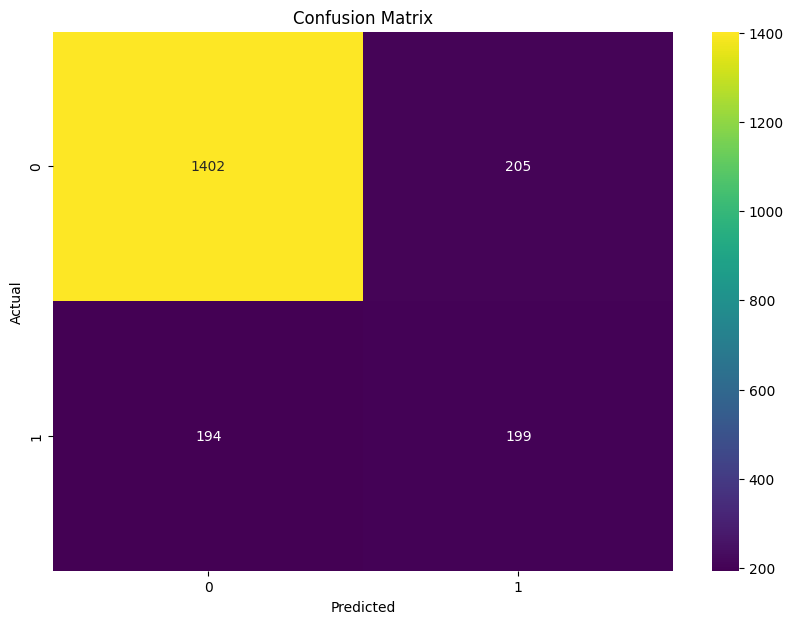

Cross-validated performance: Decision Tree - Accuracy: 0.92, Precision: 0.87, Recall: 0.98, F1-Score: 0.92
Best parameters found: {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Confusion Matrix for K-Nearest Neighbors:


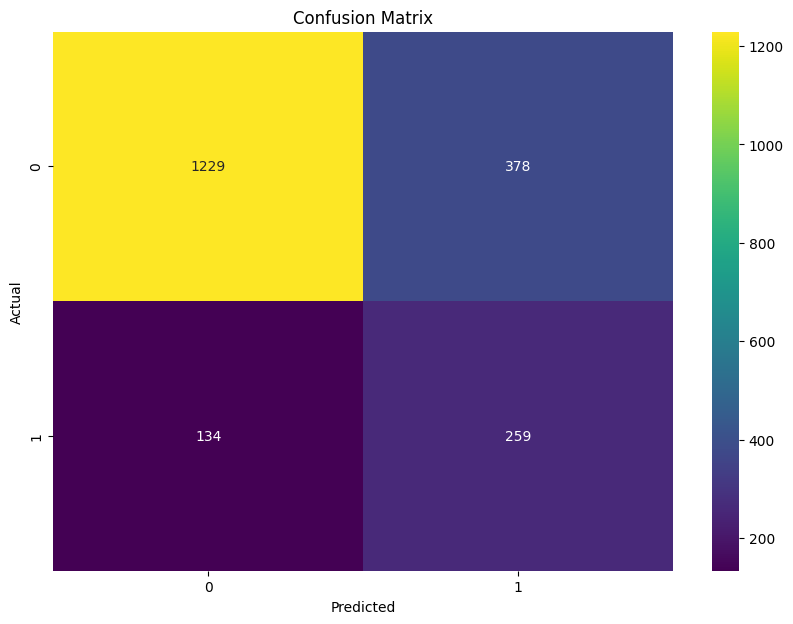

Cross-validated performance: K-Nearest Neighbors - Accuracy: 0.88, Precision: 0.81, Recall: 0.99, F1-Score: 0.89


In [19]:
# Decision Tree Classifier
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# K-Neighbors Classifier

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Support Vector Machine Classifier

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}


# Define the parameter grid for MLPClassifier

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
}


param_grids = {
    "Decision Tree": param_grid_dt,
    "K-Nearest Neighbors": param_grid_knn,
    "Support Vector Machine": param_grid_svc,
    "Neural Network": param_grid_mlp
}

optimized_results = {}

# Perform Grid Search for each classifier
for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[name], cv=cv, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_sampled, y_train_sampled)
    # Best parameters found by Grid Search
    best_params = grid_search.best_params_
    print(f"Best parameters found: {best_params}")

    # Get the best model
    best_model = grid_search.best_estimator_
    # Evaluate the best model
    y_pred = best_model.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {name}:")
    plot_confusion_matrix(cm)

    accuracy, precision, recall, f1 = cross_evaluate_classifier(best_model, X_train_sampled, y_train_sampled, cv)
    print(f"Cross-validated performance: {name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")
    optimized_results[name] = [accuracy, precision, recall, f1]

optimized_results_df = pd.DataFrame.from_dict(results_sampled, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("Original dataset:")
print(results_df)
print("Sampled dataset:")
print(optimized_results_df)

# Plot results
#plot_results(optimized_results_df)




# Improving the Model

We will try to improve the model by performing the following steps: (TODO: Add more details)

- Confusion Matrix
- Cross-Validation
- Over/Under Sampling
- Parameter Tuning
- Grid Search

- Adjust Learning Rate
- Use early stop
- Standardize the data